In [1]:
import sys
sys.path.insert(0, "/home/katharina/vame_approach/VAME")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from vame.analysis.kinutils import KinVideo, create_grid_video
import os
from datetime import datetime
from vame.util.auxiliary import read_config
import logging
import re
from pathlib import Path
from IPython import display
from sklearn.manifold import TSNE
import umap

from ipywidgets import Output, GridspecLayout
from vame.analysis.visualize import create_aligned_mouse_video, create_pose_snipplet, create_visual_comparison,thin_dataset_iteratively
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(asctime)s: %(message)s')


%reload_ext autoreload
%autoreload 2

Using CUDA
GPU active: True
GPU used: GeForce RTX 3090


## 1 ) Load latent vectors

In [2]:
PROJECT_PATH = "/home/katharina/vame_approach/themis_tail_belly_align"

anchor_idx = 4000 # select a time point to find similar neighbors to

anchor_idx = int(335.6* 120) # standing mouse
#anchor_idx = int(373.32 * 120) # walking mouse+ tick at the end

SHOW_ALIGNED = True # if True create an aligned video to create snipplets from; otherwise use original video
min_dist_nn_factor = 1 # config["time_window"] * min_dist_nn_factor will define the min distance in time points between the anchor and between sampled neighbors
align_landmark_idx = [8,16] # landmarks to use for alignment of the videos

trained_models = [
    (datetime.strptime(element, "%m-%d-%Y-%H-%M"), element)
    for element in os.listdir(os.path.join(PROJECT_PATH, "model"))
]
# sort by time step
trained_models.sort(key=lambda x: x[0])
latest_model = trained_models[-1][-1]

config_file = os.path.join(PROJECT_PATH, "model", latest_model, "config.yaml")
config = read_config(config_file)
# select landmark file
landmark_file = config["video_sets"][0]
data_path = os.path.join(
        PROJECT_PATH,
        "results",
        latest_model,
        landmark_file,
        config["model_name"],
        "kmeans-" + str(config["n_init_kmeans"]),
    )
latent_vectors = np.load(
        os.path.join(data_path, "latent_vector_" + landmark_file + ".npy")
    )

In [3]:
# extract landmark data and names
landmarks_orig = pd.read_csv(
        os.path.join(PROJECT_PATH, "landmarks", landmark_file + ".csv"), header=[0, 1],
    )
column_names = landmarks_orig.columns
landmark_names = [col_name[0] for col_name in column_names if col_name[-1] == "x"]

landmark_data_file = os.path.join(
        PROJECT_PATH, "data", landmark_file, landmark_file + "-PE-seq.npy"
    )
landmark_data_aligned = np.load(landmark_data_file).T
# reshape to (N_samples, N_landmarks, 2)
landmark_data_aligned = landmark_data_aligned.reshape(landmark_data_aligned.shape[0], -1, 2)

/home/katharina/anaconda3/envs/venv_VAME/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## 2) Sample anchor latent embedding and visualize together with its nearest neighbors vs distant samples

In [4]:
window_start = max(0, anchor_idx - int(config["time_window"] * min_dist_nn_factor))
window_end = min(len(latent_vectors), anchor_idx + int(config["time_window"] * min_dist_nn_factor))
selected_latent_vector = latent_vectors[anchor_idx, :]

dist_orig = np.sqrt(np.sum((latent_vectors - selected_latent_vector.reshape(1,-1))**2, axis=1))

time_points = np.arange(0, latent_vectors.shape[0])
time_points = np.concatenate([time_points[0:window_start], time_points[window_end:-1]])
latent_vectors = np.concatenate([latent_vectors[0:window_start], latent_vectors[window_end:-1]])
# distances between each latent vector and the selected one excluding the distances of latent vectors corresponding to temporally close frames
dist = np.concatenate([dist_orig[0:window_start], dist_orig[window_end:-1]])

# select n neighbors, and enshure the neighbors are separated by a min time span
selected_neighbor_idx = []
while len(selected_neighbor_idx) < 8 and len(dist) > 0:
    n_idx = np.argmin(dist)
    selected_neighbor_idx.append(time_points[n_idx])
    # remove all distances close to the selected anchor
    is_far_away = np.abs(time_points - time_points[n_idx]) > int(config["time_window"] * min_dist_nn_factor)
    dist = dist[is_far_away]
    time_points = time_points[is_far_away]

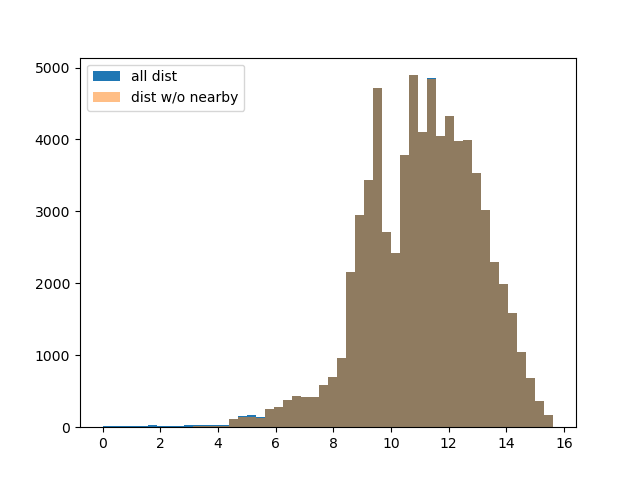

In [5]:
# Plot histogramm of distances
%matplotlib widget
# plot dist showing the neighbors but not the excluded ones?
# plotting dist removing only the nearby neighbors
bins = 50
hist_range = (min(dist_orig), max(dist_orig))
dist_wo_nearby = np.concatenate([dist_orig[0:window_start], dist_orig[window_end:-1]])
plt.hist(dist_orig,bins=bins, range=hist_range, label="all dist")
plt.hist(dist_wo_nearby, bins=bins, range=hist_range, alpha=0.5, label="dist w/o nearby")
plt.legend()

### 2.1) Visualize anchor vs nearest neighbors

In [6]:
# get corresponding video
video_df = pd.read_csv(os.path.join(PROJECT_PATH, "video_info.csv"))
video_id = int(re.findall(r"\d+", landmark_file)[0])
video_file = os.path.join(
            *video_df[video_df["video_id"] == video_id][
                ["vid_folder", "vid_file"]
            ].values[0]
        )
subject, date, camera_pos, video_name = Path(video_file).parts[-4:]


In [7]:
# all selected time points including anchor and its nearest neighbors
time_ids = [anchor_idx, *selected_neighbor_idx]
# change from frames to seconds by dividing with fps
if SHOW_ALIGNED:
    video_name, ending = os.path.basename(video_file).split(".")
    aligned_video_path = os.path.join(
        PROJECT_PATH,
        "results", "align", "a" + video_name + "." + ending)
    if not os.path.exists(aligned_video_path):
        landmark_file_path = os.path.join(PROJECT_PATH, "landmarks", landmark_file+".csv")
        create_aligned_mouse_video(
            video_file,
            landmark_file,
            align_landmark_idx,
            os.path.dirname(aligned_video_path),
            crop_size=(300, 300))

    selected_video_file = aligned_video_path
else:
    selected_video_file = video_file
#print(selected_video_file)

video = KinVideo(selected_video_file, view=camera_pos)
video.probevid()
video_clip_duration = config["time_window"]/video.getfps()


video_clip_data = [(selected_video_file, t_id/ video.getfps(), (0,0,video.width,video.height)) for t_id in time_ids]
print(video_clip_data)
grid_video_name = create_grid_video(video_clip_data,video_clip_duration,speed=0.5) # duration is in seconds!!
display.Video(grid_video_name, embed=True,html_attributes="loop autoplay", width=600,height=600)


[('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 335.6, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 336.8, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 409.8833333333333, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 483.6333333333333, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 353.2916666666667, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 504.4916666666667, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 52.03333333333333, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 328.7416666666667, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results

INFO: 2022-05-19 12:39:15,473: Scene 0 done (100%).
INFO: 2022-05-19 12:39:15,474: Concatenating 1 scenes.


In [8]:
## create full pose video and then sample the snipplets
video_name = os.path.basename(video_file)
pose_video_file = os.path.join(PROJECT_PATH, "results", "poses_"+video_name)
if not os.path.exists(pose_video_file):
    crop_size = 400
    # min max normalize the data to a fixed grid shape for visualization
    landmark_name = os.path.basename(landmark_file).split(".")[0]
    # reshape to (N_samples, N_landmarks, 2)
    landmark_data_aligned = np.load(
        os.path.join(PROJECT_PATH, "data", landmark_name, landmark_name + "-PE-seq.npy")
    ).T
    landmark_data_aligned = landmark_data_aligned.reshape(
        landmark_data_aligned.shape[0], -1, 2
    )
    landmark_data_trafo = (
        (landmark_data_aligned - landmark_data_aligned.min())
        / (landmark_data_aligned.max() - landmark_data_aligned.min())
        * (crop_size - 1)
    )
    column_names = pd.read_csv(landmark_file, header=[0, 1]).columns
    landmark_names = [col_name[0] for col_name in column_names if col_name[-1] == "x"]
    time_ids = np.arange(0, len(landmark_data_trafo))
    create_pose_snipplet(
        landmark_data_trafo,
        landmark_names,
        time_ids,
        pose_video_file,
        crop_size=(crop_size, crop_size),
    )
pose_video = KinVideo(pose_video_file, view=camera_pos)
pose_video.probevid()

pose_video_clip_data = [(pose_video_file, t_id/ pose_video.getfps(), (0,0,pose_video.width,pose_video.height)) for t_id in time_ids]
pose_grid_video_name = create_grid_video(pose_video_clip_data,video_clip_duration,speed=0.5) # duration is in seconds!!
display.Video(pose_grid_video_name, embed=True,html_attributes="loop autoplay", width=600,height=600)

INFO: 2022-05-19 12:39:16,067: Scene 0 done (100%).
INFO: 2022-05-19 12:39:16,068: Concatenating 1 scenes.


### 2.2) Visualize anchor vs distant samples

In [9]:
## Visualize Anchor together with distant embeddings
# select other embeddings from the 80% distance percentiles
dist_percentile = 80

dist_thr = np.percentile(dist_orig, dist_percentile)

time_idx_other = np.where(dist_orig > dist_thr)[0].reshape(-1)
print(time_idx_other)
sampled_idx = np.random.choice(time_idx_other, 8, replace=False)
# select anchors
video_clip_data_distant = [(selected_video_file, t_id/ video.getfps(), (0,0,video.width,video.height)) for t_id in [anchor_idx, *sampled_idx]]
print(video_clip_data)
grid_video_name_distant = create_grid_video(video_clip_data_distant,video_clip_duration,speed=0.5) # duration is in seconds!!
display.Video(grid_video_name_distant, embed=True,html_attributes="loop autoplay", width=600,height=600)


[   77    78    79 ... 72221 72222 72223]
[('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 335.6, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 336.8, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 409.8833333333333, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 483.6333333333333, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 353.2916666666667, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 504.4916666666667, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 52.03333333333333, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 328.7416666666667, (0, 0, 300, 300)), ('/home/katharina/vam

INFO: 2022-05-19 12:39:16,607: Scene 0 done (100%).
INFO: 2022-05-19 12:39:16,607: Concatenating 1 scenes.


### 2.3) Compare video clips of a bunch of randomly selected anchors vs neighbors and distant samples

In [10]:
pick_n_anchors = 3 # how many anchor ids to pick randomly

latent_vectors_all = np.load(
        os.path.join(data_path, "latent_vector_" + landmark_file + ".npy")
    )

random_anchor_ids = np.random.choice(np.arange(0, latent_vectors_all.shape[0]), pick_n_anchors, replace=False)
min_frame_distance = int(config["time_window"] * min_dist_nn_factor)

video = KinVideo(selected_video_file, view=camera_pos)
video.probevid()
video_clip_duration = config["time_window"]/video.getfps()

video_stack = []
for a_idx in random_anchor_ids:
    video_stack.append(create_visual_comparison(a_idx, latent_vectors_all, min_frame_distance, selected_video_file,video_clip_duration, upper_dist_percentile=80))

# plot next to each other: left side: anchor and its 8 closest neighbors; right side anchor and 8 samples belonging to the 
# 20% of the most distant latent vectors wrt. the anchor embedding
grid = GridspecLayout(pick_n_anchors, 2)
# sorted video files
for i_row, video_pair in enumerate(video_stack):
    for j_vid,video_f in enumerate(video_pair):
        out = Output()
        with out:
            display.display(display.Video(video_f, embed=True, html_attributes="loop autoplay", width=450,height=450))
        grid[i_row, j_vid] = out
grid


INFO: 2022-05-19 12:39:17,261: Scene 0 done (100%).
INFO: 2022-05-19 12:39:17,261: Concatenating 1 scenes.


[('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 600.7166666666667, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 246.15833333333333, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 368.55, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 105.725, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 308.0, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 129.36666666666667, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 183.75, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 224.48333333333332, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4'

INFO: 2022-05-19 12:39:17,808: Scene 0 done (100%).
INFO: 2022-05-19 12:39:17,808: Concatenating 1 scenes.
INFO: 2022-05-19 12:39:18,399: Scene 0 done (100%).
INFO: 2022-05-19 12:39:18,400: Concatenating 1 scenes.


[('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 95.575, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 89.15833333333333, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 114.61666666666666, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 142.45, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 206.75833333333333, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 79.81666666666666, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 27.591666666666665, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 183.50833333333333, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/r

INFO: 2022-05-19 12:39:18,950: Scene 0 done (100%).
INFO: 2022-05-19 12:39:18,951: Concatenating 1 scenes.
INFO: 2022-05-19 12:39:19,539: Scene 0 done (100%).
INFO: 2022-05-19 12:39:19,539: Concatenating 1 scenes.


[('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 211.19166666666666, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 514.6916666666667, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 94.16666666666667, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 137.23333333333332, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 97.76666666666667, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 187.74166666666667, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 99.93333333333334, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 39.25833333333333, (0, 0, 300, 300)), ('/home/katharina/vame_approach/them

INFO: 2022-05-19 12:39:20,081: Scene 0 done (100%).
INFO: 2022-05-19 12:39:20,082: Concatenating 1 scenes.


GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

## 3) Diluting the latent space by removing samples iteratively

In [11]:
min_frame_rate = config["time_window"]
min_remaining_dataset = 0.1 # minimum fraction of remaining samples  e.g. 0.1 = 10%
neighbor_percentile = 1 # remove vectors which are temporally close to the sampled anchor if the belong to its closest N% percentile of embeddings in the latent space
remaining_embeddings, remaining_time_ids = thin_dataset_iteratively(
    latent_vectors_all, min_remaining_dataset, neighbor_percentile, min_frame_rate)


Untested: 57915, Remaining: 58016
Untested: 44953, Remaining: 45152
Untested: 34238, Remaining: 34535
Untested: 25879, Remaining: 26271
Untested: 18632, Remaining: 19109
Untested: 12595, Remaining: 13164
Untested: 7829, Remaining: 8476


In [12]:
tsne_thinned = TSNE(perplexity=30).fit_transform(remaining_embeddings)

/home/katharina/anaconda3/envs/venv_VAME/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/katharina/anaconda3/envs/venv_VAME/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [13]:
umap_func = umap.UMAP(n_components=2,min_dist=0.01,n_neighbors=int(len(remaining_embeddings) * 0.01), random_state=config["random_state"])
umap_vectors = umap_func.fit_transform(remaining_embeddings)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


## 3.1) Sample and visualize anchors and neighbors / distant sampples from the thinned dataset

In [16]:
pick_n_anchors = 5 # how many anchor ids to pick randomly

random_anchor_ids = np.random.choice(np.arange(0, remaining_embeddings.shape[0]), pick_n_anchors, replace=False)
min_frame_distance = int(config["time_window"] * min_dist_nn_factor)

video = KinVideo(selected_video_file, view=camera_pos)
video.probevid()
video_clip_duration = config["time_window"]/video.getfps()

video_stack = []
sampled_idx_stack = []
for a_idx in random_anchor_ids:
    output = create_visual_comparison(a_idx, remaining_embeddings, min_frame_distance, selected_video_file,video_clip_duration, upper_dist_percentile=80, time_idx=remaining_time_ids, return_sampled_idx=True)
    video_close, video_distant, samples_close, samples_distant = output
    video_stack.append((video_close, video_distant))
    sampled_idx_stack.append((samples_close, samples_distant))

# plot next to each other: left side: anchor and its 8 closest neighbors; right side anchor and 8 samples belonging to the 
# 20% of the most distant latent vectors wrt. the anchor embedding
grid = GridspecLayout(pick_n_anchors, 2)
# sorted video files
for i_row, video_pair in enumerate(video_stack):
    for j_vid,video_f in enumerate(video_pair):
        out = Output()
        with out:
            display.display(display.Video(video_f, embed=True, html_attributes="loop autoplay", width=450,height=450))
        grid[i_row, j_vid] = out
grid

INFO: 2022-05-19 12:41:55,635: Scene 0 done (100%).
INFO: 2022-05-19 12:41:55,636: Concatenating 1 scenes.


[('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 486.15, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 331.025, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 339.30833333333334, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 472.2, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 326.94166666666666, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 392.78333333333336, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 508.1666666666667, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 452.8, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4',

INFO: 2022-05-19 12:41:56,205: Scene 0 done (100%).
INFO: 2022-05-19 12:41:56,205: Concatenating 1 scenes.
INFO: 2022-05-19 12:41:56,830: Scene 0 done (100%).
INFO: 2022-05-19 12:41:56,831: Concatenating 1 scenes.


[('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 228.89166666666668, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 520.7666666666667, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 316.825, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 248.96666666666667, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 279.2083333333333, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 512.4666666666667, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 245.13333333333333, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 162.35, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/r

INFO: 2022-05-19 12:41:57,413: Scene 0 done (100%).
INFO: 2022-05-19 12:41:57,414: Concatenating 1 scenes.
INFO: 2022-05-19 12:41:58,046: Scene 0 done (100%).
INFO: 2022-05-19 12:41:58,047: Concatenating 1 scenes.


[('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 48.375, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 265.45, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 212.51666666666668, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 278.15, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 250.93333333333334, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 130.10833333333332, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 230.38333333333333, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 552.975, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP

INFO: 2022-05-19 12:41:58,625: Scene 0 done (100%).
INFO: 2022-05-19 12:41:58,625: Concatenating 1 scenes.
INFO: 2022-05-19 12:41:59,252: Scene 0 done (100%).
INFO: 2022-05-19 12:41:59,252: Concatenating 1 scenes.


[('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 207.075, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 18.4, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 220.06666666666666, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 80.075, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 209.38333333333333, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 116.2, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 283.19166666666666, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 92.01666666666667, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 

INFO: 2022-05-19 12:41:59,840: Scene 0 done (100%).
INFO: 2022-05-19 12:41:59,841: Concatenating 1 scenes.
INFO: 2022-05-19 12:42:00,473: Scene 0 done (100%).
INFO: 2022-05-19 12:42:00,473: Concatenating 1 scenes.


[('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 71.48333333333333, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 96.8, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 527.275, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 155.84166666666667, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 112.39166666666667, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 78.525, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 252.01666666666668, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 259.775, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4'

INFO: 2022-05-19 12:42:01,041: Scene 0 done (100%).
INFO: 2022-05-19 12:42:01,042: Concatenating 1 scenes.


GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

### 3.2) Visualize the sampled anchors with their neighbors and distant samples in a t-SNE and UMAP

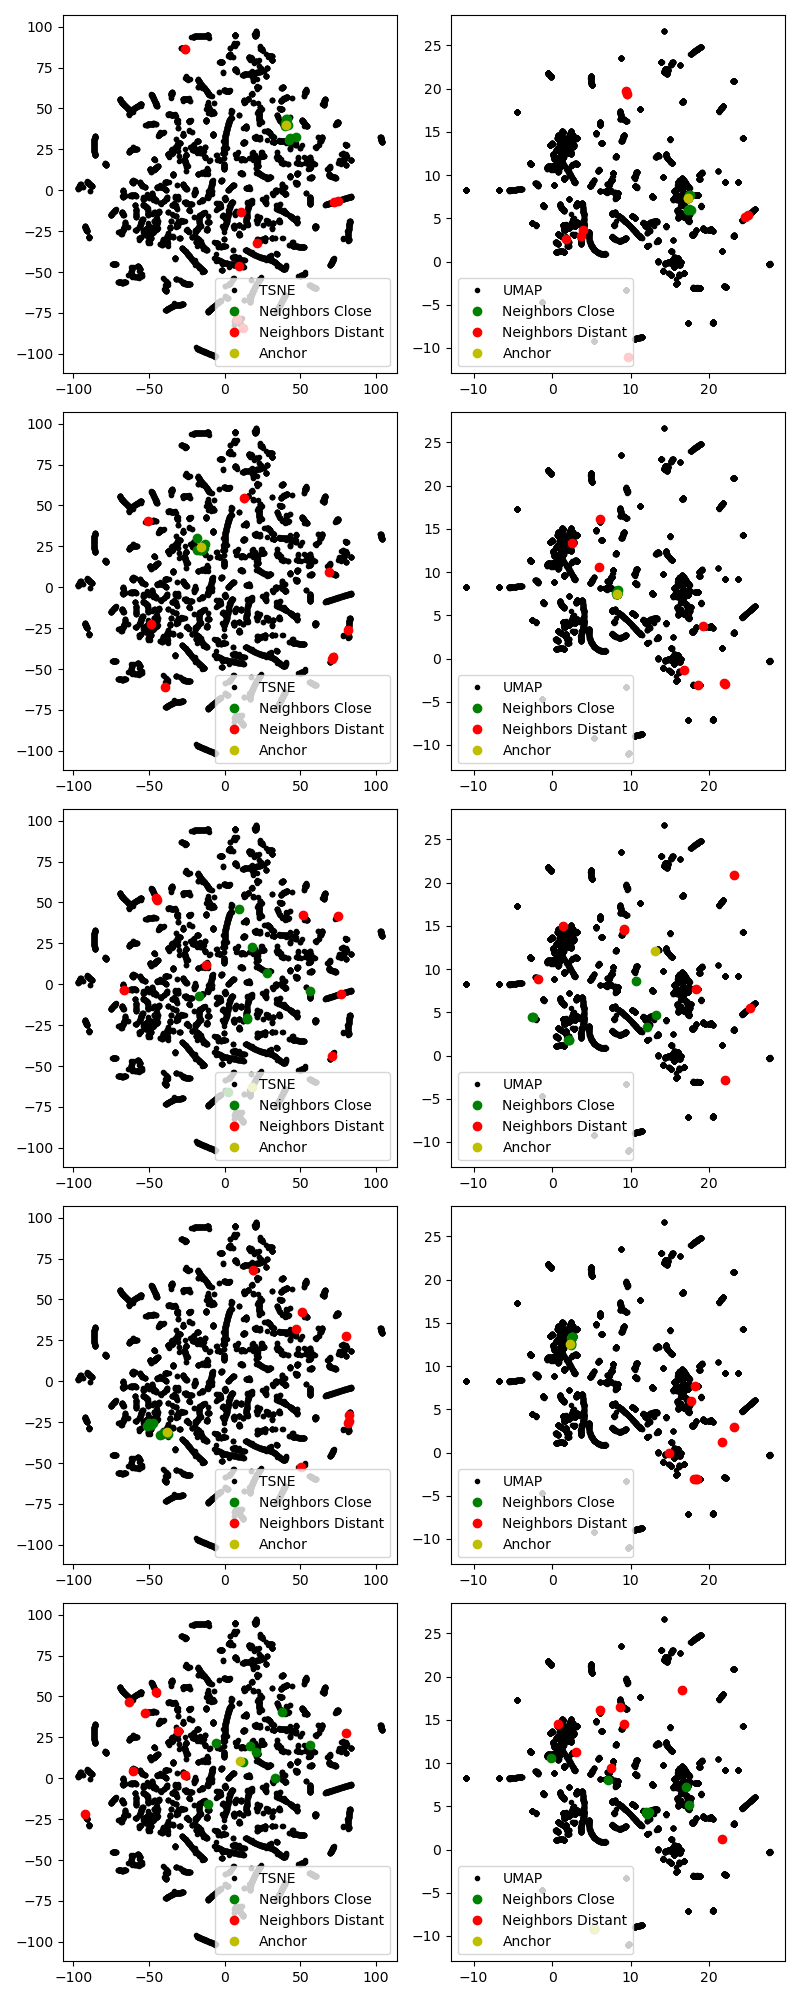

In [19]:
# visualize the sampled points in the TSNE plot
%matplotlib widget

fig, ax = plt.subplots(len(sampled_idx_stack), 2)
fig.set_size_inches(4 * 2, len(sampled_idx_stack) * 4)
for i_row, (s_close, s_distant) in enumerate(sampled_idx_stack):
    anchor_idx = s_close[0]
    ax[i_row, 0].plot (tsne_thinned[:, 0], tsne_thinned[:, 1], 'k.', label='TSNE')
    ax[i_row, 0].plot (tsne_thinned[np.isin(remaining_time_ids, s_close[1:]), 0], tsne_thinned[np.isin(remaining_time_ids, s_close[1:]), 1], 'go', label='Neighbors Close')
    ax[i_row, 0].plot (tsne_thinned[np.isin(remaining_time_ids, s_distant[1:]), 0], tsne_thinned[np.isin(remaining_time_ids, s_distant[1:]), 1], 'ro', label='Neighbors Distant')
    ax[i_row, 0].plot (tsne_thinned[remaining_time_ids == anchor_idx, 0], tsne_thinned[remaining_time_ids == anchor_idx, 1], 'yo', label='Anchor')
    
    ax[i_row, 1].plot (umap_vectors[:, 0], umap_vectors[:, 1], 'k.', label='UMAP')
    ax[i_row, 1].plot (umap_vectors[np.isin(remaining_time_ids, s_close[1:]), 0], umap_vectors[np.isin(remaining_time_ids, s_close[1:]), 1], 'go', label='Neighbors Close')
    ax[i_row, 1].plot (umap_vectors[np.isin(remaining_time_ids, s_distant[1:]), 0], umap_vectors[np.isin(remaining_time_ids, s_distant[1:]), 1], 'ro', label='Neighbors Distant')
    ax[i_row, 1].plot (umap_vectors[remaining_time_ids == anchor_idx, 0], umap_vectors[remaining_time_ids == anchor_idx, 1], 'yo', label='Anchor')
    
    ax[i_row, 0].legend()
    ax[i_row, 1].legend()
    
plt.tight_layout()
